# Data Balancing and Bias Mitigation Strategies

**Dataset:** Women in Data Science (91,713 encounters)  
**Task:** Understanding Data  
**Date:** February 17, 2025  
**Authors:** Mackenzie Meni & Jeremy Balch

### To Do List

- [x] Upsampling and downsampling and assess performance by category  
- [ ] Debiasing strategies  
- [x] Switch model architecture (RF, XGBoost, etc.)  
- [ ] Switch feature set (use all features, use subset of features)  
- [x] Switch evaluation metric (AUROC, Accuracy, etc.)  
- [x] Bootstrap for confidence intervals 


# Import all necessary packages

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tableone import TableOne
import warnings
from sklearn.model_selection import train_test_split
import joblib
import seaborn as sns
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf

warnings.filterwarnings("ignore")


# Load all data

In [84]:
# Loading original dataset
original_data = pd.read_csv('../preprocessed_data.csv')

# Loading altered dataset
data_altered_complete = pd.read_csv('../data_altered_complete.csv')

# Loading the models for comparison

In [85]:
# Random Forest Original
original_rf_loaded = joblib.load("../original_data_random_forest_model.pkl")

# Random Forest Altered 20% African American
altered_rf_loaded = joblib.load("../altered_rf_model.pkl")

# Random Forest Altered 80% Female

# Random Forest Model with upsampled data

## Train/Test Split for Upsampling

- With stratify=y, both train and test sets will preserve the ratio of the classes from the original data, making the results more representative and the model's performance more reliable.

In [86]:
data = original_data

# Drop unnecessary columns
data = data.drop(columns=['gender_M', 'ethnicity_Other/Unknown'])

# Define features and target
X = data.drop(columns=['hospital_death'])
y = data['hospital_death']

# Split data first (before upsampling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [5]:
from sklearn.ensemble import RandomForestClassifier

# Assign class weights automatically (higher weight for underrepresented class)
rf_model_balanced = RandomForestClassifier(n_estimators=100, random_state=42, class_weight="balanced")
rf_model_balanced.fit(X_train, y_train)

# Make predictions
y_pred = rf_model_balanced.predict(X_test)
y_pred_proba = rf_model_balanced.predict_proba(X_test)[:, 1]

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"AUROC: {auroc:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))


Accuracy: 0.92
AUROC: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.99      0.96     14210
           1       0.57      0.14      0.22      1305

    accuracy                           0.92     15515
   macro avg       0.75      0.56      0.59     15515
weighted avg       0.90      0.92      0.90     15515

Confusion Matrix:
[[14075   135]
 [ 1123   182]]


# Upsampling the minority class for prediction

This function balances an imbalanced dataset by duplicating (upsampling) the minority class so that it has the same number of samples as the majority class.

**🔍 Example Before & After**

| Class         | Original Count | After Upsampling |
|--------------|---------------|------------------|
| Survived (0) | 10,000        | 10,000          |
| Died (1)     | 2,000         | 10,000 (upsampled) |


In [35]:
# **True Upsampling (Duplicate Minority Class)**
def upsample_minority(X, y):
    df = pd.concat([X, y], axis=1)
    
    # Separate majority and minority classes
    majority = df[df['hospital_death'] == 0]
    minority = df[df['hospital_death'] == 1]
    
    print(majority.shape)
    print(minority.shape)
    # Upsample the minority class by repeating existing samples
    minority_upsampled = minority.sample(n=len(majority), replace=True, random_state=42)

    # Combine the upsampled minority class with the majority class
    upsampled_df = pd.concat([majority, minority_upsampled])

    # Shuffle the dataset to mix samples well
    upsampled_df = upsampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return upsampled_df.drop(columns=['hospital_death']), upsampled_df['hospital_death']

# Apply the upsampling and train the Random forest model

In [23]:

# Apply upsampling
X_train_upsampled, y_train_upsampled = upsample_minority(X_train, y_train)

# Train a Random Forest model on upsampled data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_upsampled, y_train_upsampled)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"AUROC: {auroc:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save model
joblib.dump(rf_model, "../upsampled_random_forest_model.pkl")


(56842, 39)
(5218, 39)
Accuracy: 0.92
AUROC: 0.83
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.98      0.96     14210
           1       0.52      0.27      0.36      1305

    accuracy                           0.92     15515
   macro avg       0.73      0.63      0.66     15515
weighted avg       0.90      0.92      0.91     15515

Confusion Matrix:
[[13882   328]
 [  948   357]]


['../upsampled_random_forest_model.pkl']

## Upsampled Model Results Summary

**Comparison of Original to upsampled**

|  | **Original Model** | **Upsampled Model** | **Changes in the Upsampled Model Compared to Original** |
|--------------------|----------------|----------------|----------------|
| **True Positives (Correct Deaths)** | 269 | **357** | **+88 (Better at catching deaths)** |
| **False Negatives (Missed Deaths)** | 1,032 | **948** | **-84 (Fewer missed high-risk patients)** |
| **False Positives (Wrongly Predicted Deaths)** | 187 | **328** | **+141 (More cautious in predicting risk)** |
| **True Negatives (Correctly Predicted Survivals)** | 14,027 | **13,882** | **-145 (Slight decrease in correctly classified survivals)** |



The upsampled model improves detection of high-risk patients by reducing missed deaths (false negatives) from 1,032 to 948 and correctly identifying 88 more deaths than the original model. However, this comes with a trade-off—more false positives, increasing from 187 to 328, meaning the model is now more cautious in predicting risk.

Overall, the model prioritizes catching more hospital deaths, which is often preferable in healthcare settings where missing critical cases is riskier than raising extra alerts.

# Let's try downsampling the majority class instead


### Downsampling the Majority Class for Prediction

This function balances an imbalanced dataset by reducing (downsampling) the majority class so that it has the same number of samples as the minority class. Instead of adding synthetic or duplicate data, it randomly removes majority-class examples to create a more balanced dataset.

🔍 Example Before & After

| Class         | Original Count | After Downsampling |
|--------------|---------------|------------------|
| Survived (0) | 10,000        | 2,000  (downsampled) |
| Died (1)     | 2,000         | 2,000  |


This method helps prevent the model from overfitting to the majority class while ensuring that both classes are treated equally during training.

In [25]:
# **True Downsampling (Reduce Majority Class)**
def downsample_majority(X, y):
    df = pd.concat([X, y], axis=1)
    
    # Separate majority and minority classes
    majority = df[df['hospital_death'] == 0]
    minority = df[df['hospital_death'] == 1]
    
    print("Majority class size before downsampling:", majority.shape)
    print("Minority class size:", minority.shape)

    # Downsample the majority class to match the minority class
    majority_downsampled = majority.sample(n=len(minority), random_state=42)

    # Combine the downsampled majority class with the minority class
    downsampled_df = pd.concat([majority_downsampled, minority])

    # Shuffle the dataset to mix samples well
    downsampled_df = downsampled_df.sample(frac=1, random_state=42).reset_index(drop=True)

    return downsampled_df.drop(columns=['hospital_death']), downsampled_df['hospital_death']

## Apply the downsampling and retrain a random forest model

In [26]:
data = original_data

# Drop unnecessary columns
data = data.drop(columns=['gender_M', 'ethnicity_Other/Unknown'])

# Define features and target
X = data.drop(columns=['hospital_death'])
y = data['hospital_death']

# Split data first (before upsampling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Apply downsampling
X_train_downsampled, y_train_downsampled = downsample_majority(X_train, y_train)

# Train a Random Forest model on upsampled data
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_downsampled, y_train_downsampled)

# Make predictions
y_pred = rf_model.predict(X_test)
y_pred_proba = rf_model.predict_proba(X_test)[:, 1]

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred)
auroc = roc_auc_score(y_test, y_pred_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"AUROC: {auroc:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Save model
joblib.dump(rf_model, "../downsampled_random_forest_model.pkl")


Majority class size before downsampling: (56842, 39)
Minority class size: (5218, 39)
Accuracy: 0.77
AUROC: 0.84
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.77      0.86     14210
           1       0.23      0.78      0.36      1305

    accuracy                           0.77     15515
   macro avg       0.60      0.77      0.61     15515
weighted avg       0.91      0.77      0.82     15515

Confusion Matrix:
[[10893  3317]
 [  287  1018]]


['../downsampled_random_forest_model.pkl']

### perhaps make a similar table to the one above? 

## Downsampled Model Results Summary
After downsampling, the model learns more evenly from both classes, leading to higher recall for the minority class (78%) but lower precision (23%).

- Accuracy (77%) is lower than the original model, but this is expected since we now prioritize balancing class predictions.
- AUROC (0.84) shows the model is still good at distinguishing between classes.
- Recall for hospital deaths (78%) improved significantly, meaning the model is much better at catching high-risk patients.
- Precision for hospital deaths (23%) is low, indicating more false positives.
- False negatives dropped from 1,032 (original model) to 287, meaning fewer missed critical cases.

The trade-off: fewer missed deaths (higher recall) but more false alarms (lower precision). This approach ensures more cautious risk prediction, which is often preferable in healthcare applications.

# Analyzing the bias per category


In [ ]:
# Choose which categories to analyze
original_data.columns

## Flexible Bias Assessment Function
This code checks if the AI model is fair by seeing how well it predicts hospital outcomes for different groups, like gender and ethnicity. It looks at accuracy (how often the model is right) and AUROC (how well it separates high-risk from low-risk patients).

If the model performs worse for certain groups, it might be biased, meaning it doesn't work equally well for everyone. This helps us identify unfairness and improve the model to make healthcare predictions more fair and reliable.

In [62]:

# **Flexible Bias Assessment Function**
def assess_bias(model, X_test, y_test, feature_name):
    """Evaluate model performance for different demographic groups."""
    
    # Ensure the feature exists in the dataset
    if feature_name not in X_test.columns:
        print(f"Skipping {feature_name}: Not found in dataset")
        return pd.DataFrame(columns=["Category", "Accuracy", "AUROC"])
    
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Check if model supports `predict_proba` (some models like SVM do not)
    if hasattr(model, "predict_proba"):
        y_pred_proba = model.predict_proba(X_test)[:, 1]
    else:
        y_pred_proba = y_pred  # Use predictions directly if no probabilities are available
    
    # Analyze performance across each category
    categories = X_test[feature_name].unique()
    results = []

    for category in categories:
        mask = X_test[feature_name] == category  # Boolean mask
        y_true_group = y_test[mask]
        y_pred_group = y_pred[mask]
        y_proba_group = y_pred_proba[mask]

        if len(y_true_group) == 0:
            continue  # Skip if no data for this category

        accuracy_group = accuracy_score(y_true_group, y_pred_group)
        auroc_group = roc_auc_score(y_true_group, y_proba_group) if len(set(y_true_group)) > 1 else np.nan  # Avoid AUROC error for single class

        results.append([category, accuracy_group, auroc_group])

    return pd.DataFrame(results, columns=["Category", "Accuracy", "AUROC"])


# **Example: Running Bias Analysis for Any Model**

    # Choose which features to evaluate
def evaluate_model(model, X_test, y_test):
    features_to_check = ["gender_F", "ethnicity_Caucasian", "ethnicity_African American", "ethnicity_Hispanic", "ethnicity_Native American"]

    for feature in features_to_check:
        print(f"\nBias Analysis for {feature}:")
        bias_results = assess_bias(model, X_test, y_test, feature)
        print(bias_results)




In [ ]:
# Evaluate the models

model = joblib.load('../upsampled_random_forest_model.pkl')



print("\n🔍 Evaluating Random Forest:")
evaluate_model(original_rf_loaded, X_test, y_test)





🔍 Evaluating Random Forest:

Bias Analysis for gender_F:
   Category  Accuracy     AUROC
0      True  0.984388  0.978182
1     False  0.987032  0.987096

Bias Analysis for ethnicity_Caucasian:
   Category  Accuracy     AUROC
0     False  0.987024  0.987603
1      True  0.985454  0.981697

Bias Analysis for ethnicity_African American:
   Category  Accuracy     AUROC
0     False  0.985601  0.982761
1      True  0.987611  0.985203

Bias Analysis for ethnicity_Hispanic:
   Category  Accuracy     AUROC
0     False  0.985807  0.982350
1      True  0.986111  0.996257

Bias Analysis for ethnicity_Native American:
   Category  Accuracy    AUROC
0     False  0.985820  0.98281
1      True  0.985816  0.99750


## Comparing AUROC

# Key Results 

1. Significant Drop in AUROC for African Americans
   - The largest drop in AUROC is seen for ethnicity_African American.
   - The original model (blue) had strong predictive power, while the biased model (red) shows a major decline in performance.
   - This suggests the altered dataset has disproportionately harmed predictions for this group.

The altered dataset caused disproportionate harm to African Americans.

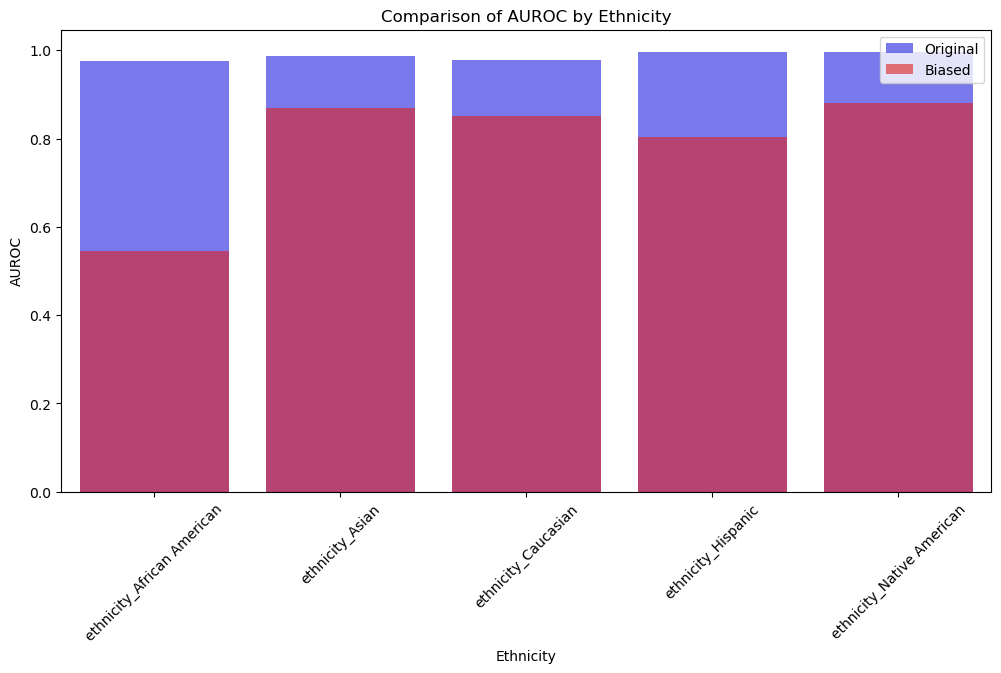

In [87]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import joblib
from sklearn.metrics import roc_auc_score

# Load Models
original_rf_loaded = joblib.load("../original_data_random_forest_model.pkl")
altered_rf_loaded = joblib.load("../altered_rf_model.pkl")

# Get Predictions
y_pred_proba_orig = original_rf_loaded.predict_proba(X_test)[:, 1]
y_pred_proba_bias = altered_rf_loaded.predict_proba(X_test)[:, 1]

# Example subgroup columns (one-hot encoded)
ethnicity_columns = [
    'ethnicity_African American',
    'ethnicity_Asian',
    'ethnicity_Caucasian',
    'ethnicity_Hispanic',
    'ethnicity_Native American'
]

# Function to Compute AUROC for One-Hot Encoded Ethnicity Groups
def calculate_auroc_by_one_hot(X_test, y_test, model, ethnicity_columns):
    """Compute AUROC scores for different ethnic groups using one-hot encoding."""
    auroc_scores = {}

    for col in ethnicity_columns:
        group_indices = (X_test[col] == 1)  # Select rows where ethnicity column is active
        if sum(group_indices) > 10:  # Ensure enough samples for AUROC calculation
            y_true_group = y_test[group_indices]
            y_pred_proba_group = model.predict_proba(X_test[group_indices])[:, 1]
            auroc_scores[col] = roc_auc_score(y_true_group, y_pred_proba_group)
    
    return pd.DataFrame(auroc_scores.items(), columns=['Ethnicity', 'AUROC'])

# Compute AUROC by Ethnic Subgroup
ethnicity_auroc_orig = calculate_auroc_by_one_hot(X_test, y_test, original_rf_loaded, ethnicity_columns)
ethnicity_auroc_bias = calculate_auroc_by_one_hot(X_test, y_test, altered_rf_loaded, ethnicity_columns)

# Merge results for comparison
ethnicity_comparison = ethnicity_auroc_orig.merge(
    ethnicity_auroc_bias, on='Ethnicity', suffixes=('_Original', '_Biased')
)

# Plot AUROC Comparison
plt.figure(figsize=(12, 6))
sns.barplot(data=ethnicity_comparison, x="Ethnicity", y="AUROC_Original", color="blue", alpha=0.6, label="Original")
sns.barplot(data=ethnicity_comparison, x="Ethnicity", y="AUROC_Biased", color="red", alpha=0.6, label="Biased")

# Formatting
plt.xlabel("Ethnicity")
plt.ylabel("AUROC")
plt.title("Comparison of AUROC by Ethnicity")
plt.xticks(rotation=45)
plt.legend()

# Show the plot
plt.show()


## Next Steps

#### **Investigate Why This Happened**

- Compare feature importance between the original and biased models. Did certain features become more/less relevant?
- Check confusion matrices for each group. Did false positives or false negatives increase disproportionately?
- Examine model calibration: Is the biased model over/under-confident in certain predictions?


#### **Bias Mitigation Strategies**

- Rebalance the dataset to ensure fairer representation.
- Apply fairness-aware techniques, such as reweighting or adversarial debiasing.
- Use fairness constraints during training to reduce the disparity.

Confusion Matrix Comparison                     Ethnicity  False Positive Rate_Original  \
0  ethnicity_African American                      0.000634   
1             ethnicity_Asian                      0.000000   
2         ethnicity_Caucasian                      0.003034   
3          ethnicity_Hispanic                      0.001706   
4   ethnicity_Native American                      0.000000   

   False Negative Rate_Original  False Positive Rate_Biased  \
0                      0.144068                    0.311985   
1                      0.263158                    0.159574   
2                      0.142436                    0.154851   
3                      0.112903                    0.184300   
4                      0.125000                    0.128000   

   False Negative Rate_Biased  
0                    0.644068  
1                    0.473684  
2                    0.361493  
3                    0.419355  
4                    0.187500  


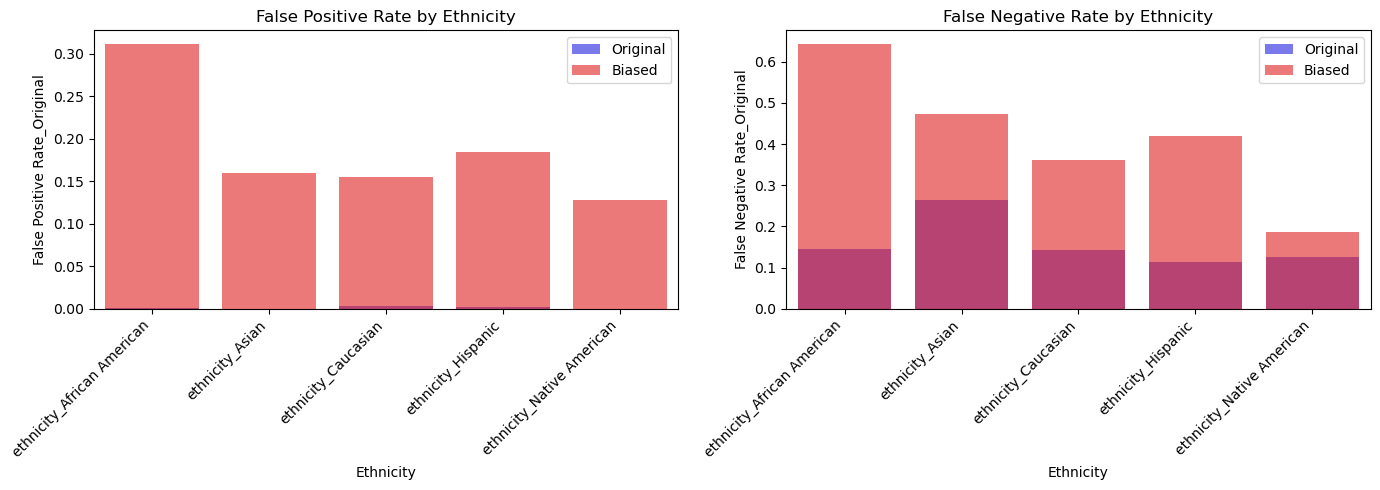

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import joblib
from sklearn.metrics import confusion_matrix

# Load Models
original_rf_loaded = joblib.load("../original_data_random_forest_model.pkl")
altered_rf_loaded = joblib.load("../altered_rf_model.pkl")

# Get Predictions
y_pred_orig = original_rf_loaded.predict(X_test)
y_pred_bias = altered_rf_loaded.predict(X_test)

# Function to Compute Confusion Matrix by Ethnic Group
def compute_confusion_by_group(X_test, y_test, y_pred, ethnicity_columns):
    """Compute confusion matrix metrics (FPR, FNR) for each ethnicity group."""
    confusion_results = []

    for col in ethnicity_columns:
        group_indices = (X_test[col] == 1)
        if sum(group_indices) > 10:  # Ensure enough samples
            y_true_group = y_test[group_indices]
            y_pred_group = y_pred[group_indices]
            
            tn, fp, fn, tp = confusion_matrix(y_true_group, y_pred_group).ravel()
            
            fpr = fp / (fp + tn) if (fp + tn) > 0 else np.nan  # False Positive Rate
            fnr = fn / (fn + tp) if (fn + tp) > 0 else np.nan  # False Negative Rate
            
            confusion_results.append({
                "Ethnicity": col,
                "False Positive Rate": fpr,
                "False Negative Rate": fnr
            })
    
    return pd.DataFrame(confusion_results)

# Compute confusion matrices for both models
confusion_orig = compute_confusion_by_group(X_test, y_test, y_pred_orig, ethnicity_columns)
confusion_bias = compute_confusion_by_group(X_test, y_test, y_pred_bias, ethnicity_columns)

# Merge results
confusion_comparison = confusion_orig.merge(confusion_bias, on="Ethnicity", suffixes=("_Original", "_Biased"))

# Print Results
print("Confusion Matrix Comparison", confusion_comparison)

# Function to Plot Confusion Matrix Comparison
def plot_confusion_matrix_comparison(confusion_df):
    """Plots the False Positive Rate (FPR) and False Negative Rate (FNR) comparisons."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # False Positive Rate Plot
    sns.barplot(
        data=confusion_df, x="Ethnicity", y="False Positive Rate_Original", color="blue", alpha=0.6, label="Original", ax=axes[0]
    )
    sns.barplot(
        data=confusion_df, x="Ethnicity", y="False Positive Rate_Biased", color="red", alpha=0.6, label="Biased", ax=axes[0]
    )
    axes[0].set_title("False Positive Rate by Ethnicity")
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")

    # False Negative Rate Plot
    sns.barplot(
        data=confusion_df, x="Ethnicity", y="False Negative Rate_Original", color="blue", alpha=0.6, label="Original", ax=axes[1]
    )
    sns.barplot(
        data=confusion_df, x="Ethnicity", y="False Negative Rate_Biased", color="red", alpha=0.6, label="Biased", ax=axes[1]
    )
    axes[1].set_title("False Negative Rate by Ethnicity")
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")

    # Adjust layout and show
    plt.tight_layout()
    plt.legend()
    plt.show()

# Plot the confusion matrix comparison
plot_confusion_matrix_comparison(confusion_comparison)


## False Positive Rate (FPR) (Left Plot)

**Key Observations:**

- African Americans have the highest FPR in the Biased Model
    - The red bar for African Americans is much larger than for other groups, indicating a major increase in false positives.
    - This suggests that the biased model incorrectly predicts positive cases (e.g., high-risk) more often for African Americans.

- Other ethnic groups show some FPR increase, but not as extreme
    - While there are small FPR increases for Asian, Hispanic, and Native American groups, they are not as pronounced.
    - The Caucasian group has almost no FPR increase, indicating less impact on false positives.

## False Negative Rate (FNR) (Right Plot)

**Key Observations:**

- African Americans experience a drastic increase in FNR in the Biased Model
    - The red bar for African Americans is much larger than the blue bar, indicating that the biased model fails to detect actual positive cases more frequently.
    - This could mean that real high-risk cases are being ignored, leading to potential harm for this group.
  
- All groups experience FNR increases, but African Americans are the worst affected

The FNR has increased for every ethnicity in the biased model.

**However, African Americans and Asians have the largest increases**, suggesting that the biased model is more likely to ignore true positives for these groups.
Caucasians, Hispanics, and Native Americans have moderate increases, but not as extreme.


<Figure size 1800x600 with 0 Axes>

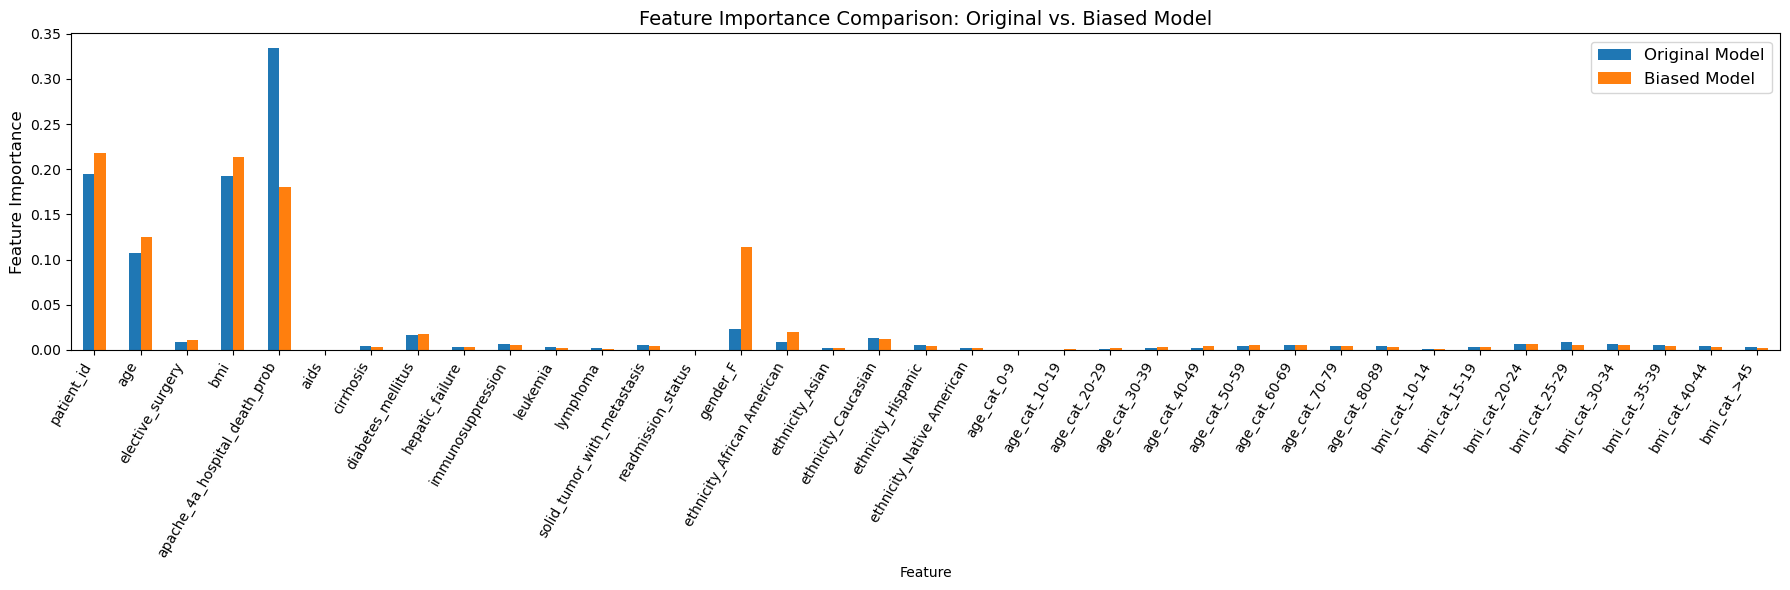

In [89]:
importances_orig = pd.DataFrame({
    'Feature': original_rf_loaded.feature_names_in_,
    'Importance_Original': original_rf_loaded.feature_importances_
})

importances_bias = pd.DataFrame({
    'Feature': altered_rf_loaded.feature_names_in_,
    'Importance_Biased': altered_rf_loaded.feature_importances_
})

# Merge for comparison
feature_importance_comparison = importances_orig.merge(importances_bias, on="Feature")

# Display Feature Importance Comparison
# print("Feature Importance Comparison", feature_importance_comparison)

# Plot Feature Importance Changes
plt.figure(figsize=(18, 6))  # Increased width for clarity
ax = feature_importance_comparison.set_index("Feature").plot(kind="bar", figsize=(18,6))

plt.title("Feature Importance Comparison: Original vs. Biased Model", fontsize=14)
plt.ylabel("Feature Importance", fontsize=12)
plt.xticks(rotation=60, ha="right", fontsize=10)  # Rotate & right-align labels
plt.yticks(fontsize=10)  # Increase y-axis label size
plt.legend(["Original Model", "Biased Model"], fontsize=12)

plt.tight_layout()  # Adjust layout for better visibility
plt.show()


## Interpretation of Feature Importance Changes

This bar chart compares the feature importance values for the original model (blue) vs. the biased model (orange). Key observations:

1. Increased Dependence on Ethnicity Variables

   - The feature "ethnicity_African American" has a significantly higher importance in the biased model (orange bar) than in the original model.
This suggests that the biased model relies more on ethnicity to make predictions, which may contribute to the observed performance degradation for African Americans (seen in the AUROC drop).

   - Other ethnicity categories (e.g., Caucasian, Hispanic, Native American) do not show significant shifts, reinforcing that the bias specifically affects one group.

2. Shift in Medical Feature Importance
   -  "elective_surgery" and "apache_4a_hospital_death_prob" have slightly reduced importance in the biased model.
   - This suggests that in the biased model, decision-making relies less on these clinical indicators and more on ethnicity-based information.
   - This can indicate dataset bias or model overfitting to altered patterns in the training data.
  
3. Stable Features

   -  General medical conditions like "diabetes_mellitus", "hepatic_failure", and "immunosuppression" remain consistent between the original and biased models.
   -  This means the model has not drastically changed clinical feature weighting, but has shifted certain key dependencies.

# Bias Metrics
- need to add details

Bias Metrics Comparison
                    Ethnicity  Disparate Impact_Original  \
0  ethnicity_African American                   0.789038   
1             ethnicity_Asian                   0.906588   
2         ethnicity_Caucasian                   0.906055   
3          ethnicity_Hispanic                   0.856163   
4   ethnicity_Native American                   0.748118   

   Disparate Impact_Biased  Equalized Odds Diff_Original  \
0                 0.624266                      0.002535   
1                 0.920943                      0.123189   
2                 0.774311                      0.003063   
3                 0.940741                      0.030299   
4                 0.981082                      0.016971   

   Equalized Odds Diff_Biased  Demographic Parity Diff_Original  \
0                    0.286022                          0.016089   
1                    0.091103                          0.006969   
2                    0.101922                        

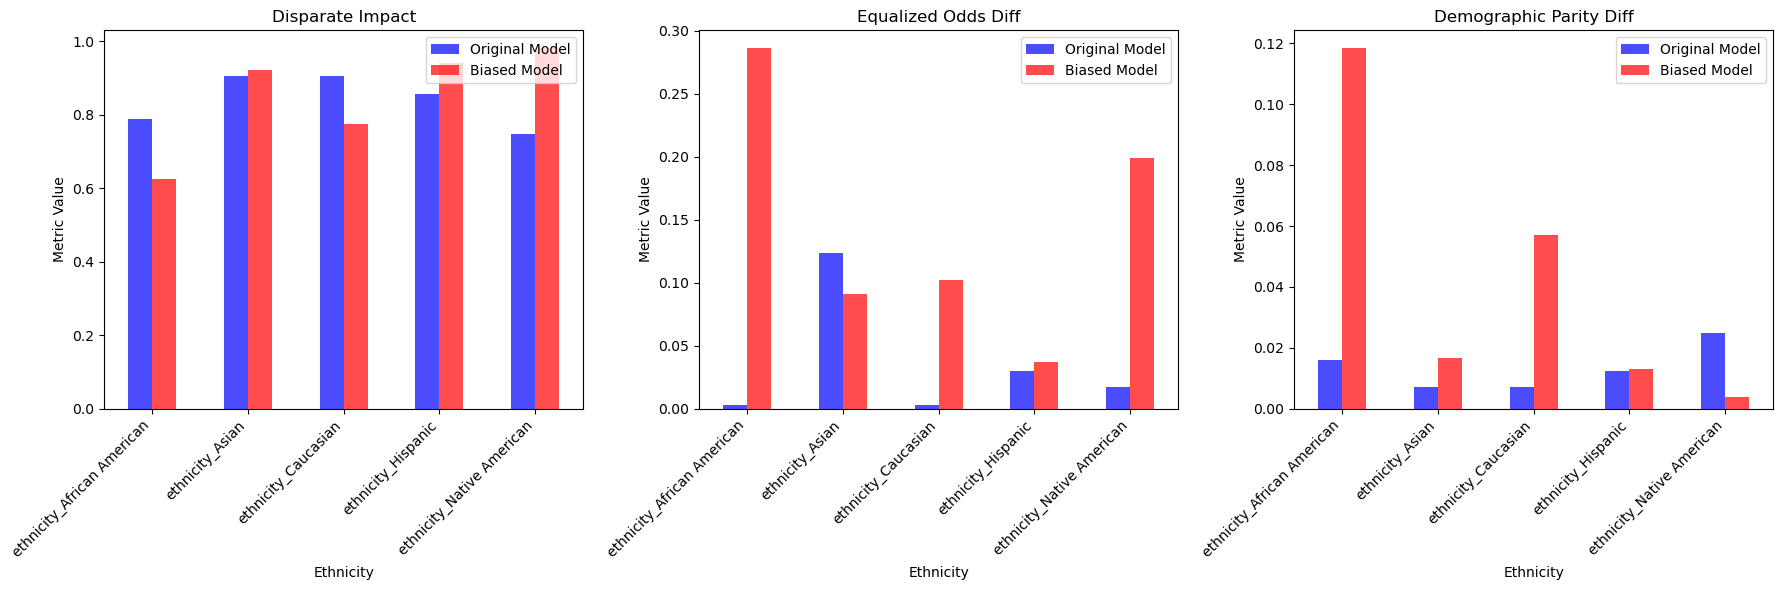

In [72]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
import matplotlib.pyplot as plt
import pandas as pd

# List of ethnic groups to analyze
ethnicity_columns = [
    'ethnicity_African American',
    'ethnicity_Asian',
    'ethnicity_Caucasian',
    'ethnicity_Hispanic',
    'ethnicity_Native American'
]

# Function to compute bias metrics per ethnic group
def compute_bias_metrics(y_test, y_pred_orig, y_pred_bias, ethnicity_columns):
    """Computes Disparate Impact, Equalized Odds Difference, and Demographic Parity Difference per ethnicity."""
    bias_results = []

    for ethnicity in ethnicity_columns:
        di_orig = disparate_impact(y_test, y_pred_orig, ethnicity)
        di_bias = disparate_impact(y_test, y_pred_bias, ethnicity)

        eo_orig = equalized_odds_difference(y_test, y_pred_orig, sensitive_features=X_test[ethnicity])
        eo_bias = equalized_odds_difference(y_test, y_pred_bias, sensitive_features=X_test[ethnicity])

        dp_orig = demographic_parity_difference(y_test, y_pred_orig, sensitive_features=X_test[ethnicity])
        dp_bias = demographic_parity_difference(y_test, y_pred_bias, sensitive_features=X_test[ethnicity])

        bias_results.append({
            "Ethnicity": ethnicity,
            "Disparate Impact_Original": di_orig,
            "Disparate Impact_Biased": di_bias,
            "Equalized Odds Diff_Original": eo_orig,
            "Equalized Odds Diff_Biased": eo_bias,
            "Demographic Parity Diff_Original": dp_orig,
            "Demographic Parity Diff_Biased": dp_bias
        })

    return pd.DataFrame(bias_results)

# Compute bias metrics for all ethnic groups
bias_results_df = compute_bias_metrics(y_test, y_pred_orig, y_pred_bias, ethnicity_columns)

# Display Bias Metrics
print("Bias Metrics Comparison")
print(bias_results_df)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = ["Disparate Impact", "Equalized Odds Diff", "Demographic Parity Diff"]
columns = [
    ("Disparate Impact_Original", "Disparate Impact_Biased"),
    ("Equalized Odds Diff_Original", "Equalized Odds Diff_Biased"),
    ("Demographic Parity Diff_Original", "Demographic Parity Diff_Biased"),
]

for i, (metric, (orig_col, bias_col)) in enumerate(zip(metrics, columns)):
    ax = axes[i]
    bias_results_df.plot(
        kind="bar", x="Ethnicity", y=[orig_col, bias_col],
        color=["blue", "red"], alpha=0.7, ax=ax
    )
    ax.set_title(metric)
    ax.set_ylabel("Metric Value")
    ax.set_xticklabels(bias_results_df["Ethnicity"], rotation=45, ha="right")
    ax.legend(["Original Model", "Biased Model"])

plt.tight_layout()
plt.show()


## Disparate Impact (Left Plot)

**What this means:**
- Measures the selection rate ratio between groups (values closer to 1 are fair).
-  Values below 0.8 suggest bias (disproportionate selection for certain groups).

**Key Observations:**

- African Americans have the lowest Disparate Impact in the Biased Model (~0.6), showing a significant drop compared to the original model.
- Hispanic and Native American groups also experience a decline, but not as severe.
- Caucasian and Asian groups remain close to 1, suggesting they were less affected by the bias.

**Takeaway:**

The biased model disproportionately reduces selection rates for African Americans and Hispanics.


## Equalized Odds Difference (Middle Plot)
**What this means:**

- Measures differences in False Positive and False Negative Rates between groups.
- Higher values indicate unfair error distribution.

**Key Observations:**

- African Americans have the largest Equalized Odds Difference (~0.28 in the Biased Model), meaning they experience the most unfair misclassification errors.
- Native Americans also see a big jump (~0.2), suggesting higher misclassification disparities.
- Caucasians have the lowest difference, meaning they are the least affected by changes in error rates.


**Takeaway:**

The biased model significantly increases misclassification disparities for African American and Native American groups.

## Demographic Parity Difference (Right Plot)
**What this means:**

- Measures differences in selection rates between groups.
- Higher values indicate that certain groups are systematically disadvantaged.
  
**Key Observations:**

- African Americans see the highest Demographic Parity Difference (~0.12 in the Biased Model), suggesting they are systematically less selected than others.
- Hispanics also experience an increase (~0.06), but less severe.
- Native Americans’ fairness improves slightly in the biased model, suggesting selection rates were slightly adjusted in their favor.

**Takeaway:**
The biased model disproportionately reduces the selection rate for African Americans and Hispanics.

# Debiasing Techniques

# Reweighting biased data set for training

Accuracy: 0.74
AUROC: 0.75
Classification Report:
              precision    recall  f1-score   support

         0.0       0.78      0.91      0.84     11709
         1.0       0.43      0.21      0.28      3806

    accuracy                           0.74     15515
   macro avg       0.61      0.56      0.56     15515
weighted avg       0.69      0.74      0.70     15515

Confusion Matrix:
[[10662  1047]
 [ 3011   795]]

Fairness Metrics After Reweighing:
                    Ethnicity  Demographic Parity Diff  Equalized Odds Diff
0  ethnicity_African American                 0.096920             0.117408
1   ethnicity_Native American                 0.041447             0.089468


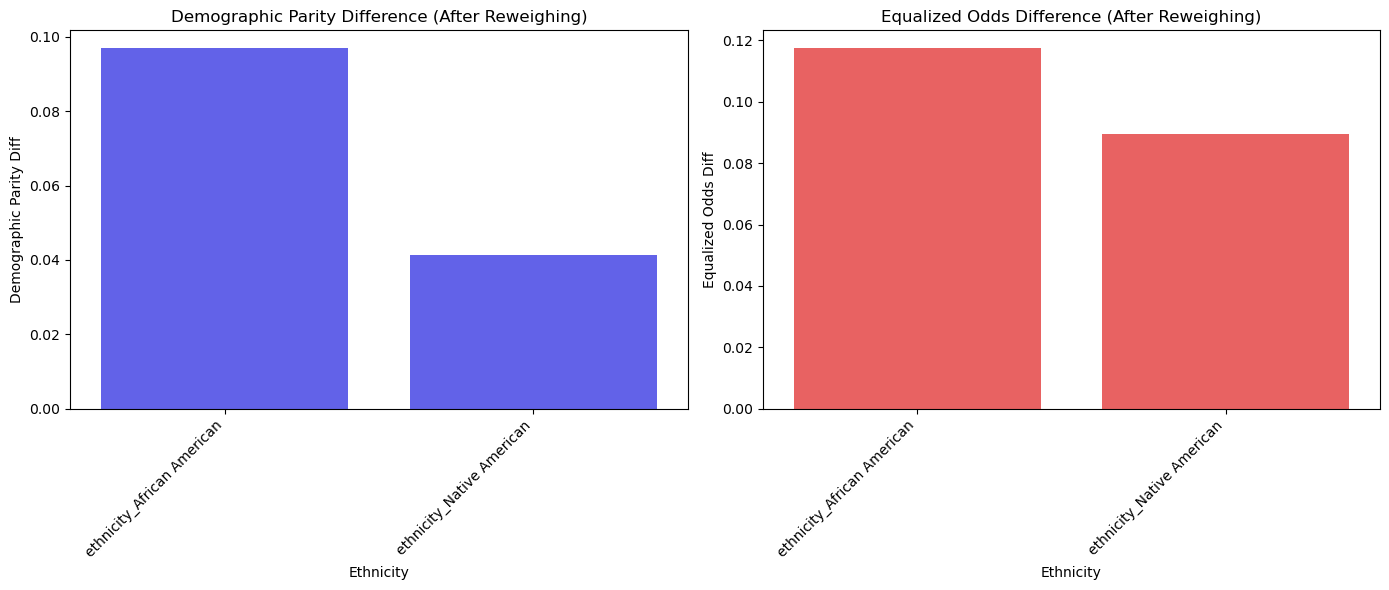

In [90]:
from aif360.algorithms.preprocessing import Reweighing
from aif360.datasets import BinaryLabelDataset
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, classification_report
import matplotlib.pyplot as plt
import pandas as pd

# Load Data
data_altered = pd.read_csv('../data_altered_complete.csv')

# Drop unused columns
data_altered = data_altered.drop(columns=['gender_M','ethnicity_Other/Unknown'])

# Define features and target variable
X = data_altered.drop('hospital_death', axis=1)  
y = data_altered['hospital_death']               

# Perform the train-test split
X_train_altered, X_test_altered, y_train_altered, y_test_altered = train_test_split(X, y, test_size=0.2, random_state=42)

# **1️⃣ Modify Protected Attributes Based on Bias Analysis**
protected_attrs = [ 'ethnicity_African American', 'ethnicity_Native American']  # Added Native American

# Convert dataset into BinaryLabelDataset format
dataset = BinaryLabelDataset(
    df=data_altered,
    label_names=['hospital_death'],
    protected_attribute_names=protected_attrs
)

# **2️⃣ Adjust Reweighing to Focus on Most Biased Groups**
reweigher = Reweighing(
    unprivileged_groups=[{'ethnicity_African American': 0,  'ethnicity_Native American': 0}],
    privileged_groups=[{'ethnicity_African American': 1, 'ethnicity_Native American': 1}]
)

dataset_transf = reweigher.fit_transform(dataset)

# **3️⃣ Convert back to Pandas**
data_reweighted, _ = dataset_transf.convert_to_dataframe()
sample_weights = dataset_transf.instance_weights  

# **4️⃣ Define features and labels**
X = data_reweighted.drop(columns=['hospital_death'])
y = data_reweighted['hospital_death']

# **5️⃣ Perform train-test split**
X_train, X_test, y_train, y_test, sample_weights_train, sample_weights_test = train_test_split(
    X, y, sample_weights, test_size=0.2, random_state=42
)

# **6️⃣ Train Random Forest with Sample Weights**
rf_model_reweighted = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_reweighted.fit(X_train, y_train, sample_weight=sample_weights_train)  

# **7️⃣ Save Model**
joblib.dump(rf_model_reweighted, '../rf_reweighted.pkl')

# **8️⃣ Make Predictions**
y_pred_reweighted = rf_model_reweighted.predict(X_test)
y_pred_reweighted_proba = rf_model_reweighted.predict_proba(X_test)[:, 1]

# **9️⃣ Evaluate Performance**
accuracy = accuracy_score(y_test, y_pred_reweighted)
auroc = roc_auc_score(y_test, y_pred_reweighted_proba)

print(f"Accuracy: {accuracy:.2f}")
print(f"AUROC: {auroc:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_reweighted))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_reweighted))

# **🔟 Fairness Metrics Before & After Reweighing**
def compute_fairness_metrics(y_test, y_pred, X_test, protected_attrs):
    fairness_results = []
    
    for attr in protected_attrs:
        dp = demographic_parity_difference(y_test, y_pred, sensitive_features=X_test[attr])
        eo = equalized_odds_difference(y_test, y_pred, sensitive_features=X_test[attr])
        
        fairness_results.append({"Ethnicity": attr, "Demographic Parity Diff": dp, "Equalized Odds Diff": eo})
    
    return pd.DataFrame(fairness_results)

# Compute for Reweighted Model
fairness_reweighted = compute_fairness_metrics(y_test, y_pred_reweighted, X_test, protected_attrs)

# Print results
print("\nFairness Metrics After Reweighing:")
print(fairness_reweighted)

# **📊 Visualization of Fairness Metrics**
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Demographic Parity Difference
sns.barplot(data=fairness_reweighted, x="Ethnicity", y="Demographic Parity Diff", color="blue", alpha=0.7, ax=axes[0])
axes[0].set_title("Demographic Parity Difference (After Reweighing)")
axes[0].set_xticklabels(fairness_reweighted["Ethnicity"], rotation=45, ha="right")

# Equalized Odds Difference
sns.barplot(data=fairness_reweighted, x="Ethnicity", y="Equalized Odds Diff", color="red", alpha=0.7, ax=axes[1])
axes[1].set_title("Equalized Odds Difference (After Reweighing)")
axes[1].set_xticklabels(fairness_reweighted["Ethnicity"], rotation=45, ha="right")

plt.tight_layout()
plt.show()


# Comparing metrics after reweighting

Bias Metrics Comparison
                    Ethnicity  Disparate Impact_Original  \
0  ethnicity_African American                   0.931775   
1   ethnicity_Native American                   0.692609   

   Disparate Impact_Biased  Disparate Impact_Reweighted  \
0                 0.990559                      0.52798   
1                 0.899770                      0.65180   

   Equalized Odds Diff_Original  Equalized Odds Diff_Biased  \
0                      0.006247                    0.003481   
1                      0.029981                    0.116879   

   Equalized Odds Diff_Reweighted  Demographic Parity Diff_Original  \
0                        0.117408                          0.005413   
1                        0.089468                          0.022956   

   Demographic Parity Diff_Biased  Demographic Parity Diff_Reweighted  
0                        0.001996                            0.096920  
1                        0.023329                            0.041447

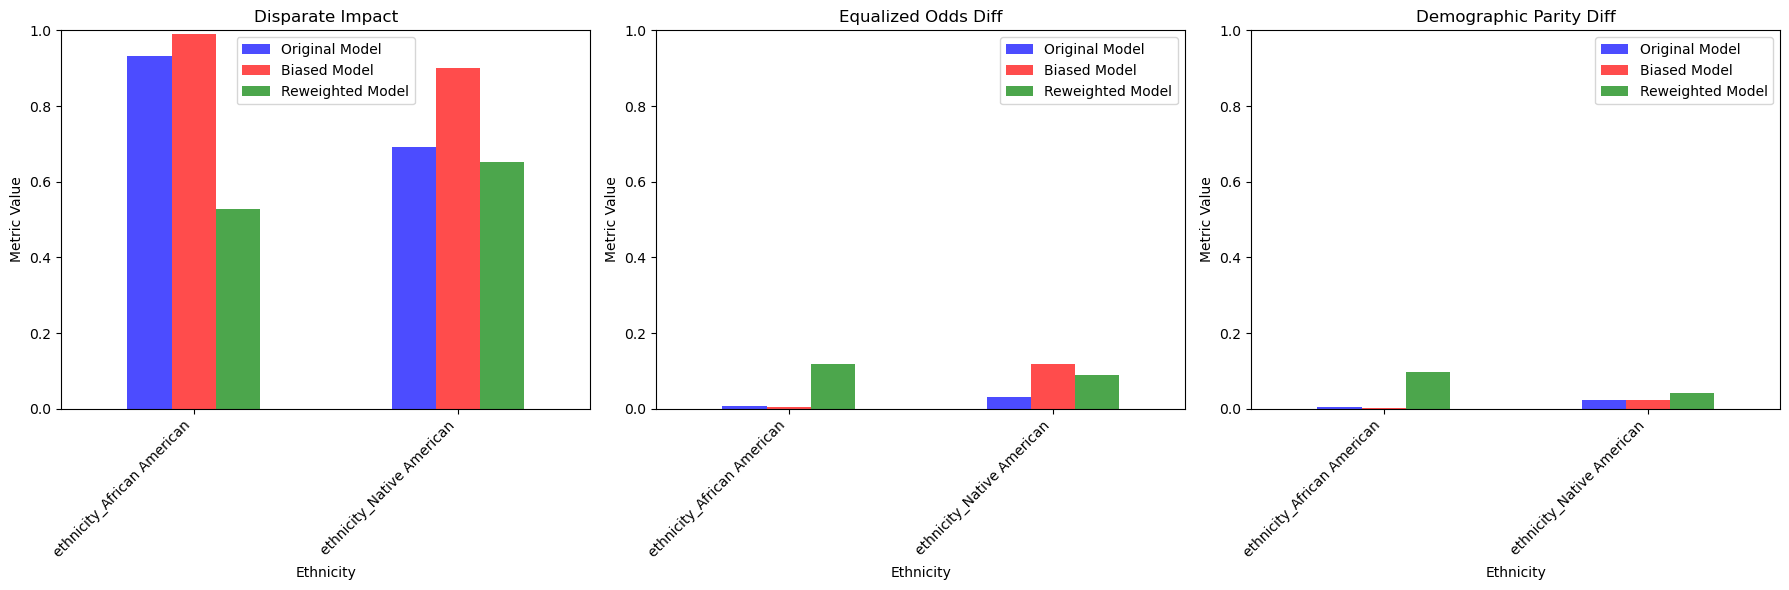

In [94]:
from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
import matplotlib.pyplot as plt
import pandas as pd

# List of ethnic groups to analyze
ethnicity_columns = [
    'ethnicity_African American',
    #'ethnicity_Asian',
    #'ethnicity_Caucasian',
    #'ethnicity_Hispanic',
    'ethnicity_Native American'
]

# Function to compute bias metrics per ethnic group
def compute_bias_metrics(y_test, y_pred_orig, y_pred_bias, y_pred_reweighted, ethnicity_columns):
    """Computes Disparate Impact, Equalized Odds Difference, and Demographic Parity Difference per ethnicity."""
    bias_results = []

    for ethnicity in ethnicity_columns:
        di_orig = disparate_impact(y_test, y_pred_orig, ethnicity)
        di_bias = disparate_impact(y_test, y_pred_bias, ethnicity)
        di_reweighted = disparate_impact(y_test, y_pred_reweighted,ethnicity)

        eo_orig = equalized_odds_difference(y_test, y_pred_orig, sensitive_features=X_test[ethnicity])
        eo_bias = equalized_odds_difference(y_test, y_pred_bias, sensitive_features=X_test[ethnicity])
        eo_reweighted = equalized_odds_difference(y_test, y_pred_reweighted, sensitive_features=X_test[ethnicity])

        dp_orig = demographic_parity_difference(y_test, y_pred_orig, sensitive_features=X_test[ethnicity])
        dp_bias = demographic_parity_difference(y_test, y_pred_bias, sensitive_features=X_test[ethnicity])
        dp_reweighted = demographic_parity_difference(y_test, y_pred_reweighted, sensitive_features=X_test[ethnicity])

        bias_results.append({
            "Ethnicity": ethnicity,
            "Disparate Impact_Original": di_orig,
            "Disparate Impact_Biased": di_bias,
            "Disparate Impact_Reweighted": di_reweighted,
            "Equalized Odds Diff_Original": eo_orig,
            "Equalized Odds Diff_Biased": eo_bias,
            "Equalized Odds Diff_Reweighted": eo_reweighted,
            "Demographic Parity Diff_Original": dp_orig,
            "Demographic Parity Diff_Biased": dp_bias,
            "Demographic Parity Diff_Reweighted": dp_reweighted
        })

    return pd.DataFrame(bias_results)

# Compute bias metrics for all ethnic groups
bias_results_df = compute_bias_metrics(y_test, y_pred_orig, y_pred_bias, y_pred_reweighted, ethnicity_columns)

# Display Bias Metrics
print("Bias Metrics Comparison")
print(bias_results_df)

## Visualization Fix
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics = ["Disparate Impact", "Equalized Odds Diff", "Demographic Parity Diff"]
columns = [
    ("Disparate Impact_Original", "Disparate Impact_Biased", "Disparate Impact_Reweighted"),
    ("Equalized Odds Diff_Original", "Equalized Odds Diff_Biased", "Equalized Odds Diff_Reweighted"),
    ("Demographic Parity Diff_Original", "Demographic Parity Diff_Biased", "Demographic Parity Diff_Reweighted"),
]

for i, (metric, (orig_col, bias_col, reweighted_col)) in enumerate(zip(metrics, columns)):
    ax = axes[i]
    bias_results_df.plot(
        kind="bar", x="Ethnicity", y=[orig_col, bias_col, reweighted_col],
        color=["blue", "red", "green"], alpha=0.7, ax=ax
    )
    ax.set_title(metric)
    ax.set_ylabel("Metric Value")
    ax.set_xticklabels(bias_results_df["Ethnicity"], rotation=45, ha="right")
    ax.legend(["Original Model", "Biased Model", "Reweighted Model"])
    
    # Add consistent y-axis scaling
    ax.set_ylim(0, 1)

plt.tight_layout()
plt.show()


# Comparing Fairness Metrics after reweighting